In [40]:
import pandas as pd
import os

# Read CSV
data = pd.read_csv('breakhis_data/Folds.csv')

# Clean 'mag' column so it's always int (e.g., "100X" → 100)
data['mag'] = data['mag'].astype(str).str.replace('X', '', regex=False).str.strip().astype(int)

# Dataset directory
root_dir = 'breakhis_data/BreaKHis_v1/'

# Classes
class_names = ['benign', 'malignant']

# Number of workers for parallel data loading
NUM_WORKERS = os.cpu_count()  


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class BreakHisDataset(Dataset):
    def __init__(self, data, root_dir, group=None, mag=None, transform=None):
        if isinstance(data, str):
            self.data = pd.read_csv(data)
        else:
            self.data = data.copy()

        if group is not None:
            self.data = self.data[self.data['grp'] == group]

        if mag is not None:
            self.data = self.data[self.data['mag'] == mag]

        self.data = self.data.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        
        # Extract benign/malignant
        self.data['label'] = self.data['filename'].apply(lambda x: x.split('/')[3])
        self.class_names = sorted(self.data['label'].unique())
        self.data['label_int'] = self.data['label'].apply(lambda x: self.class_names.index(x))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = row['label_int']
        return image, label

    def class_distribution(self, plot=False, title="Class Distribution"):
        counts = self.data['label'].value_counts()
        if plot:
            sns.barplot(x=counts.index, y=counts.values)
            plt.title(title)
            plt.ylabel("Count")
            plt.xlabel("Class")
            plt.show()
        return counts

Train Distribution:
 label
malignant    3882
benign       1631
Name: count, dtype: int64


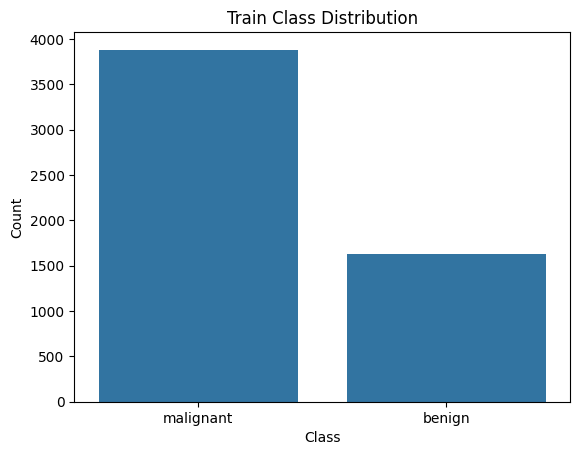

Validation Distribution:
 label
malignant    917
benign       407
Name: count, dtype: int64


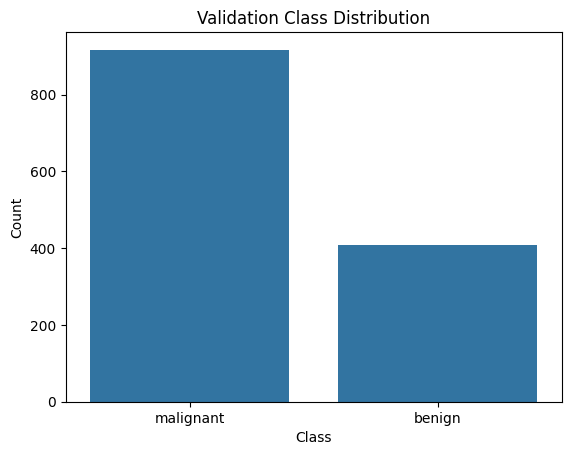

Test Distribution:
 label
malignant    2386
benign       1182
Name: count, dtype: int64


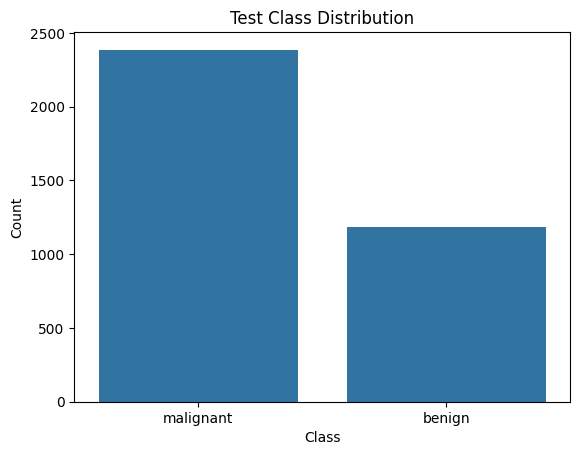

label
malignant    2386
benign       1182
Name: count, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split
# Data Transformations
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


# Split data into training, validation, and test sets

# Only training rows
train_data_full = data[data['grp'] == "train"]

# Split
train_df, val_df = train_test_split(
    train_data_full,
    test_size=0.2,
    stratify=train_data_full['filename'].apply(lambda x: x.split('/')[3]),
    random_state=42
)
train_df['label'] = train_df['filename'].apply(lambda x: x.split('/')[3])


# Test set from CSV
test_df = data[data['grp'] == "test"]


# Create datasets

magnification = 100  # change as needed

train_dataset = BreakHisDataset(train_df, root_dir, mag=magnification, transform=train_transform)
val_dataset = BreakHisDataset(val_df, root_dir, mag=magnification, transform=val_test_transform)
test_dataset = BreakHisDataset(test_df, root_dir, mag=magnification, transform=val_test_transform)


# Class distribution plots

print("Train Distribution:\n", train_dataset.class_distribution())
train_dataset.class_distribution(plot=True, title="Train Class Distribution")

print("Validation Distribution:\n", val_dataset.class_distribution())
val_dataset.class_distribution(plot=True, title="Validation Class Distribution")

print("Test Distribution:\n", test_dataset.class_distribution())
test_dataset.class_distribution(plot=True, title="Test Class Distribution")


Theres a data imbalance in our dataset as the number of malignant images are far more than those of benign. To avoid the model being biased towards the malignant class, we use the method of upsampling. Now the normal way to do this is to duplicate the images of the smaller class, perhaps with a few augmentations to avoid the similarities. There is another way to address the imbalance, weighted dataloaders. 

Weighted Dataloaders load the dataset with a higher weight to the minority class images and vice versa for the majority images.

In [45]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# Calculate class counts
class_counts = train_df['label'].value_counts().sort_index().values
print("Class counts:", class_counts)

# Compute weights for each class: inverse of counts
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)

# Assign weight to each sample
sample_weights = class_weights[train_dataset.data['label_int'].values]

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)




# DataLoader using sampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)

# Validation loader (no sampler, no shuffle)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


Class counts: [ 6308 14396]


In [ ]:
#model and training

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import copy

def build_model(num_classes=1):
    model = models.resnet50(pretrained=True)
    # Replace the final FC layer with a single output for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1),
        nn.Sigmoid()
    )
    return model


IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 12
SAMPLE_SIZE = len(train_dataset)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=7e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop skeleton with validation
from sklearn.metrics import precision_score, recall_score

def train(model, train_loader, val_loader):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_corrects = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
                outputs = model(inputs)
                preds = (outputs > 0.5).float()
                val_corrects += torch.sum(preds == labels.data)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = val_corrects.double() / len(val_loader.dataset)

        # Calculate precision and recall
        val_precision = precision_score(all_labels, all_preds)
        val_recall = recall_score(all_labels, all_preds)

        print(f"Validation Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_model.pth")

    model.load_state_dict(best_model_wts)
    return model

# model = train(model, train_loader, val_loader)


/home/teja-bulusu/Desktop/breakhis_start/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/teja-bulusu/Desktop/breakhis_start/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/teja-bulusu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%
